In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch


In [2]:
def generate_corners3d(whl:torch.Tensor, ry:torch.Tensor=[0], pos:torch.Tensor=[0,0], depth:torch.Tensor=[0]) -> torch.Tensor:

    """
    Inspired from kitti.utils
    Generates a representation of 3D bounding box(es) as 8 corners in camera coordinates.

    :param whl: np.ndarray, (n,3), width, height, length of the n boxes
    :param ry:  np.ndarray, (n,1), rotation around y-axis
    :param pos: np.ndarray, (n,2) position of the n boxes's center
    :param depth: np.ndarray, (n,1) depth (z) of the n boxes's center

    :return corners_3d: (n,3,8) corners of box3d in camera coords
    
    Assumes rotation around y-axis.
      7 -------- 6
     /:         /|
    4 ======== 5 |
    | :        | |
    | 3 -------|-2
    |          |/
    0 ======== 1
    ---
    y
    | x
    |/
    O ---> z
    -

    """
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0], # bottom
        [4, 5], [5, 6], [6, 7], [7, 4], # top
        [0, 4], [1, 5], [2, 6], [3, 7]  # vertical
    ]
    # cube sides to corners. Cube center at (0, 0, 0)
    # x is lenght, y is height, z is width.
    w,h,l = whl.T
    w = w.reshape(1,-1)
    h = h.reshape(1,-1)
    l = l.reshape(1,-1)
    x_corners = torch.cat([-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2]).T
    y_corners = torch.cat([-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]).T
    z_corners = torch.cat([-w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2]).T

    corners3d = torch.stack([x_corners, y_corners, z_corners], axis=2).permute(0,2,1)

    _ry = ry.reshape(1,-1)
    R = torch.cat([torch.cat([torch.cos(_ry), torch.zeros_like(_ry), torch.sin(_ry)]),
                  torch.cat([torch.zeros_like(_ry), torch.ones_like(_ry), torch.zeros_like(_ry)]),
                  torch.cat([-torch.sin(_ry), torch.zeros_like(_ry), torch.cos(_ry)])])
    R = R.T.reshape(-1, 3, 3)
    
    p3d = torch.cat([pos, depth], dim=1) # (n, 3)
    p3d = p3d.unsqueeze(dim=1) # (n, 1, 3)
    p3d = p3d.permute(0,2,1)  # (n, 3, 1)
    p3d = p3d.repeat(1,1,8) # (n, 3, 8)

    corners3d = R@corners3d
    corners3d = corners3d + p3d

    return corners3d, connections

def get_3dfigure(frame_coords=(0.0,0.0,0.0),axes_lim=(-5,5)):
    def get_fix_mins_maxs(axes_lim):
        mins = axes_lim[0]
        maxs = axes_lim[1]
        deltas = (maxs - mins) / 12.
        mins = mins + deltas / 4.
        maxs = maxs - deltas / 4.
        
        return [mins, maxs]
        
    minmax = get_fix_mins_maxs(axes_lim)

    fig = plt.figure()
    ax_3D = fig.add_subplot(projection='3d')

    ax_3D.set_xlabel('x')
    ax_3D.set_ylabel('y')
    ax_3D.set_zlabel('z')
    ax_3D.set_aspect("equal")

    # Set each axis limits
    ax_3D.set_xlim(minmax)
    ax_3D.set_ylim(minmax) 
    ax_3D.set_zlim(minmax) 

    axis_length = 4
    ref_frame_og = np.array([frame_coords[0], frame_coords[1], frame_coords[2]])
    x_vector = [ref_frame_og[0], ref_frame_og[0] + axis_length]
    y_vector = [ref_frame_og[1], ref_frame_og[1] + axis_length]
    z_vector = [ref_frame_og[2], ref_frame_og[2] + axis_length]

    ax_3D.plot(x_vector, [ref_frame_og[1], ref_frame_og[1]], [ref_frame_og[2], ref_frame_og[2]], 'r')
    ax_3D.plot([ref_frame_og[0], ref_frame_og[0]], y_vector, [ref_frame_og[2], ref_frame_og[2]], 'g')
    ax_3D.plot([ref_frame_og[0], ref_frame_og[0]], [ref_frame_og[1], ref_frame_og[1]], z_vector, 'b')

    # write frame coordinates
    ax_3D.text(ref_frame_og[0], ref_frame_og[1], ref_frame_og[2], f'  ({frame_coords[0]}, {frame_coords[1]}, {frame_coords[2]})')
    return fig, ax_3D

def plot_3dbox(ax_3D, X, Y, Z, connections_verts, box_id=0, color='k'):
    # plot vertices
    ax_3D.scatter(X, Y, Z, c='k', marker='o')

    # plot edges
    for connection in connections_verts:
        start = connection[0]
        end = connection[1]
        ax_3D.plot([X[start], X[end]], [Y[start], Y[end]], [Z[start], Z[end]], color)

    # write box id on the last vertex
    ax_3D.text(X[-1], Y[-1], Z[-1], f'  box_id: {box_id}')
    return ax_3D

In [3]:
whl = torch.tensor([[1,5,1]])
ry = torch.tensor([[0]])
pos = torch.tensor([[0,0]])
depth = torch.tensor([[0]])

p3d = torch.cat([pos, depth.reshape(-1,1)], dim=1)

corners3d, connections_verts = generate_corners3d(whl, ry, pos, depth)
X = corners3d[0,0,:]
Y = corners3d[0,1,:]
Z = corners3d[0,2,:]


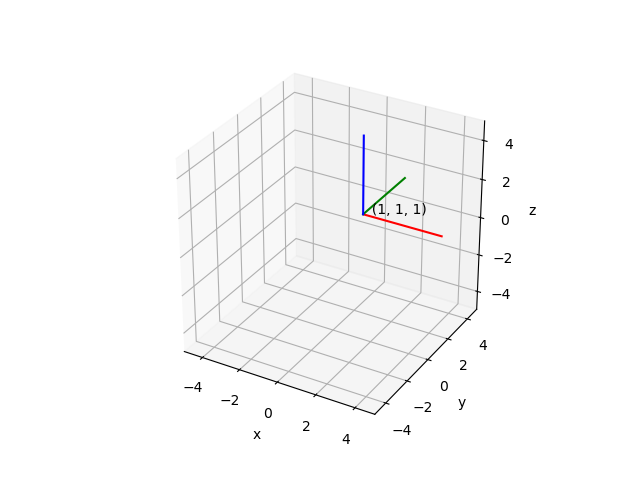

In [4]:
%matplotlib widget
fig, ax_3D = get_3dfigure(frame_coords=(1,1,1))
# ax_3D = plot_3dbox(ax_3D, X, Y, Z, connections_verts)
# ax_3D = plot_3dbox(ax_3D, X+1, Y+1, Z+1, connections_verts, box_id=1, color='r')
plt.show()